In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_selection import chi2
from sklearn import decomposition
import gensim
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity
from gensim.models import ldamodel, doc2vec, LsiModel 
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings('ignore')

In [50]:
congo = ['patrice', 'congo', 'lumumba', 'tshombe', 'leopoldville']
df_issues = pd.read_csv('../data/arab_observer_1960_1962_stopwords_aggregating.csv')
df_issues.month[df_issues.month == 'Oct'] = 'October'
df_issues.month[df_issues.month == 'Aug'] = 'August'
df_issues.month[df_issues.month == 'Sept'] = 'September'
df_issues['string_date'] = df_issues.date.astype(str)
documents = df_issues.tokenized_text.tolist()
names = [row['string_date'] for index, row in df_issues.iterrows()]

In [54]:
tokenize = lambda doc: doc.lower().split(" ")
counts = TfidfVectorizer(norm='l2',min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True, tokenizer=tokenize, ngram_range=(1,1))
counts_matrix = counts.fit_transform(documents)
dtm = counts_matrix.toarray() 
dist = euclidean_distances(dtm)
cos = 1- cosine_similarity(dtm)
norms = np.sqrt(np.sum(dtm * dtm, axis=1, keepdims=True))
dtm_normed = dtm / norms
sim = np.dot(dtm_normed, dtm_normed.T)
sim[1, 3]
keyness, _ = chi2(counts_matrix, names)
vocab = np.array(counts.get_feature_names())
ranking = np.argsort(keyness)[::-1]
rates = 1000 * dtm / np.sum(dtm, axis=1, keepdims=True)
vocab[ranking][0:100]
num_topics = 50
num_top_words = 20
clf = decomposition.NMF(n_components=num_topics, random_state=1)
doctopic = clf.fit_transform(dtm)
topic_words = []
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])

In [55]:
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t])))

Topic 0: the bizerta 's arab « said president liras world region people african states israel in it national united would million
Topic 1: yemeni margrethe princess hamza k.a.n.u 62.50 nubia ulcer squadron drachmas berbera taif pts nyerere simbel 112/6 nubian archaeology yemen 6000
Topic 2: logan lincoln avivi kroll naacp zeeb negroes myser talaries kaissouni swaziland cotton-seed frazier hacham khoga amos d'automne ameri nnamdi bois
Topic 3: musallam lavidim ܐ andrawos enkiri d'aumale lb c.m kolek ecm pirates histadrut l.i tensility blocade cm zagreb out-turn buganda oas
Topic 4: puskas beggar toynbee progeny tejada cantz burmese dahran el-badr nedava oil-possessing azolai v-day soccer ashkelon majdal u.a.s enclaves cites sappir
Topic 5: tashnak tashnaks bizerta land-owners armenians coopera tash- tenancy requisit 'i under-ground requisitioned land-owner kantars tenant armenian marel nak irriga tenants
Topic 6: bauer rogozin djamila bouhreid harmonica huiles 550.000 on-site sté nazare

In [53]:

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 20

# Run NMF
nmf = decomposition.NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = decomposition.LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)


def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic: ", topic_idx)
        for i in topic.argsort()[:-no_top_words - 1:-1]:
            print(feature_names[i])

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)


Topic:  0
king
tons
algerian
jews
gurion
industry
assembly
cotton
labour
market
Topic:  1
eichmann
laos
trial
march
jews
algerian
region
zionist
jewish
april
Topic:  2
oas
1962
algerian
court
market
cotton
tons
cease
march
april
Topic:  3
syria
syrian
damascus
reactionary
region
liras
october
reaction
officers
regime
Topic:  4
kuwait
league
july
troops
tunisia
crisis
nigeria
kassem
iraq
gurion
Topic:  5
congo
lumumba
region
belgian
katanga
imperialism
liras
imperialist
northern
tshombe
Topic:  6
algerian
bella
november
algerians
gurion
gaulle
pakistan
traffic
shall
settlement
Topic:  7
june
aligned
summit
alignment
gurion
preparatory
cyprus
kennedy
presidents
angola
Topic:  8
agrarian
tunisia
reform
region
cooperative
feddans
northern
rural
august
agricultural
Topic:  9
king
hussein
jordanian
region
october
neutralist
shah
resolution
gaulle
assembly
Topic:  10
yemen
yemeni
1962
aden
saudi
october
imam
cuba
television
sir
Topic:  11
kenyatta
kenya
liras
tunisia
august
region
labour
coas

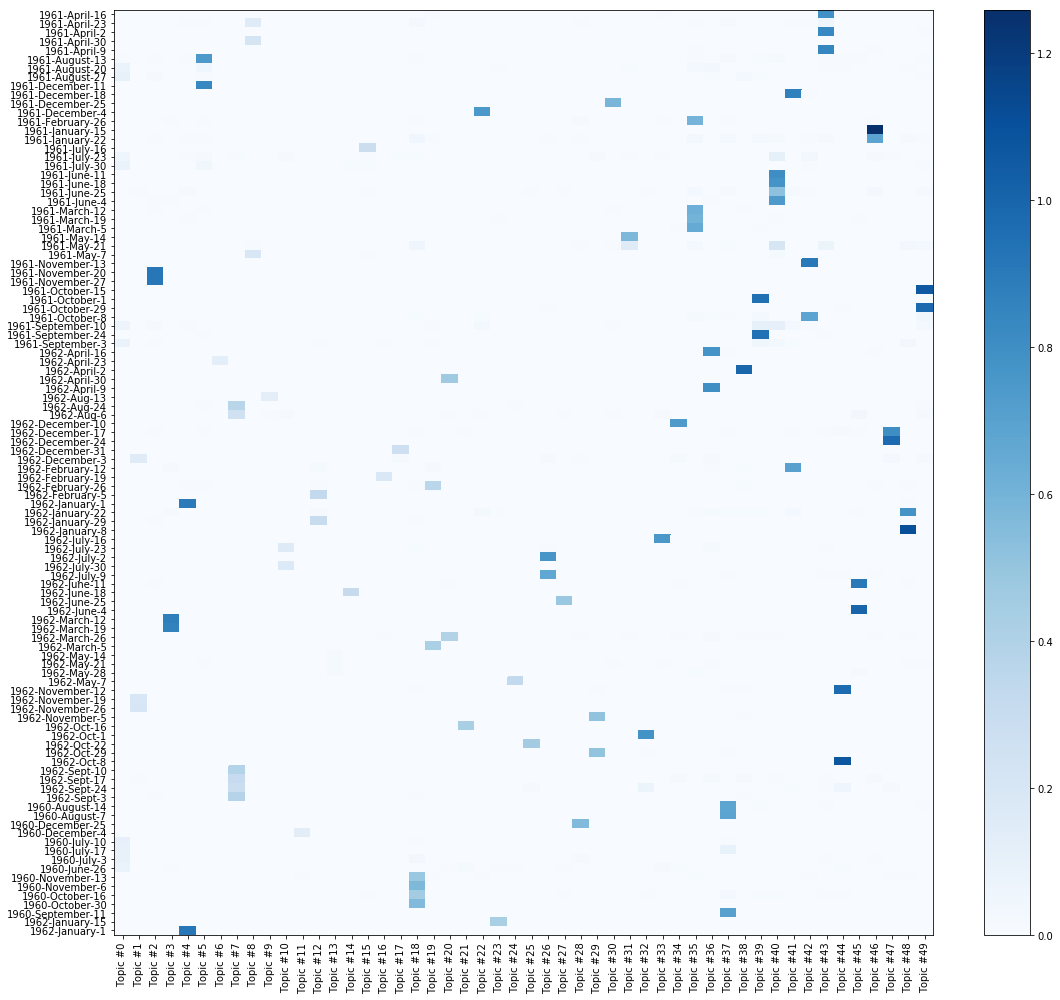

In [26]:
plt.figure(figsize=(16,14))
plt.pcolor(doctopic, norm=None, cmap='Blues')

plt.yticks(np.arange(doctopic.shape[0])+0.5, names);
N, K = doctopic.shape
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.xticks(np.arange(doctopic.shape[1])+0.5, topic_labels)
# ax = plt.gca()
# ax.tick_params(axis='x', which='major', labelsize=15)
# ax.tick_params(axis='y', which='major', labelsize=8)
plt.gca().invert_yaxis()
plt.xticks(rotation=90)
plt.colorbar(cmap='Blues')
plt.tight_layout()
plt.show()

In [12]:
def create_models(texts):
    
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=20, passes=10)
    vis_data = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
    return vis_data

docs = []
for doc in documents:
    d = doc.split(' ')
    docs.append(d)
vis_data = create_models(docs)



pyLDAvis.display(vis_data)

In [23]:
more_congo_terms = ['belgian', 'mobutu', 'kasavubu', 'katanga']
congo = congo + more_congo_terms
congo

['patrice',
 'congo',
 'lumumba',
 'tshombe',
 'leopoldville',
 'belgian',
 'mobutu',
 'kasavubu',
 'belgian',
 'mobutu',
 'kasavubu',
 'katanga']